# Rule different between SARSA and Q-learning
1. SARSA choose an action A from S first and take it
1. Observe R and S_prime
1. choose an action A_prime from S_prime
1. update Q(S,A) with Q(S_prime, A_prime) not max(Q(S_prime))
1. update S = S_prime, A = A_prime

# Result 
<h3>I run for 100000 episodes and get best reward:</h3>
<pre>
Episode 83000 finished after 818.000000 time steps 
cumulated reward: 16.000000 
exploring rate 0.010000 
learning rate 0.500000 
</pre>
but I only have mp4 with reward 10.


In [1]:
# import package needed
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
import numpy as np
from ple.games.flappybird import FlappyBird
from ple import PLE

game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

couldn't import doomish
Couldn't import doom


In [2]:
import math
import copy
from collections import defaultdict
MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:

  def __init__(self,
               bucket_range_per_feature,
               num_action,
               t=0,
               discount_factor=0.99):
    self.update_parameters(t)  # init explore rate and learning rate
    self.q_table = defaultdict(lambda: np.zeros(num_action))
    self.discount_factor = discount_factor
    self.num_action = num_action

    # how to discretize each feature in a state
    # the higher each value, less time to train but with worser performance
    # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
    self.bucket_range_per_feature = bucket_range_per_feature

  def select_action(self, state):
    # epsilon-greedy
    state_idx = self.get_state_idx(state)
    if np.random.rand() < self.exploring_rate:
      action = np.random.choice(num_action)  # Select a random action
    else:
      action = np.argmax(
          self.q_table[state_idx])  # Select the action with the highest q
    return action

  def update_policy(self, state, action, action_prime, reward, state_prime):
    state_idx = self.get_state_idx(state)
    state_prime_idx = self.get_state_idx(state_prime)
    # Update Q_value using Q-learning update rule
    best_q = (self.q_table[state_prime_idx][action_prime])
    self.q_table[state_idx][action] += self.learning_rate * (
        reward 
        + self.discount_factor * np.mean((best_q))
        - self.q_table[state_idx][action]
    )

  def get_state_idx(self, state):
    # instead of using absolute position of pipe, use relative position
    state = copy.deepcopy(state)
    state['next_next_pipe_bottom_y'] -= state['player_y']
    state['next_next_pipe_top_y'] -= state['player_y']
    state['next_pipe_bottom_y'] -= state['player_y']
    state['next_pipe_top_y'] -= state['player_y']

    # sort to make list converted from dict ordered in alphabet order
    state_key = [k for k, v in sorted(state.items())]

    # do bucketing to decrease state space to speed up training
    state_idx = []
    for key in state_key:
      state_idx.append(int(state[key] / self.bucket_range_per_feature[key]))
    return tuple(state_idx)

  def update_parameters(self, episode):
    self.exploring_rate = max(MIN_EXPLORING_RATE,
                              min(0.5, 0.99**((episode) / 30)))
    self.learning_rate = max(MIN_LEARNING_RATE, min(0.5, 0.99
                                                    **((episode) / 30)))

  def shutdown_explore(self):
    # make action selection greedy
    self.exploring_rate = 0

In [3]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
  'next_next_pipe_bottom_y': 40,
  'next_next_pipe_dist_to_player': 512,
  'next_next_pipe_top_y': 40,
  'next_pipe_bottom_y': 20,
  'next_pipe_dist_to_player': 20,
  'next_pipe_top_y': 20,
  'player_vel': 4,
  'player_y': 16
}
# init agent
agent = Agent(bucket_range_per_feature, num_action)

In [4]:
def make_anim(images, fps=60, true_image=False):
  duration = len(images) / fps
  import moviepy.editor as mpy

  def make_frame(t):
    try:
      x = images[int(len(images) / duration * t)]
    except:
      x = images[-1]

    if true_image:
      return x.astype(np.uint8)
    else:
      return ((x + 1) / 2 * 255).astype(np.uint8)

  clip = mpy.VideoClip(make_frame, duration=duration)
  clip.fps = fps
  return clip

In [5]:
from IPython.display import Image, display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 100000

for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    cum_reward = 0  # cumulate reward for this episode
    t = 0
    # select an action
    action = agent.select_action(state)

    while not env.game_over():

        # execute the action and get reward
        reward = env.act(
            env.getActionSet()[action])  # reward = +1 when pass a pipe, -5 when die

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state
        
        #choose a' from s' using policy fderived from Q
        action_prime = agent.select_action(state_prime)
        
        # update agent
        agent.update_policy(state, action, action_prime, reward, state_prime)

        # Setting up for the next iteration
        state = state_prime
        action = action_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print("Episode %d finished after %f time steps" % (episode, t))
        print("cumulated reward: %f" % cum_reward)
        print("exploring rate %f" % agent.exploring_rate)
        print("learning rate %f" % agent.learning_rate)
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("len frames:", len(frames))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
len frames: 63


 98%|███████████████████████████████████████████████████████████████████████████████▋ | 63/64 [00:00<00:00, 193.62it/s]


Episode 500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 1500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2000 finished after 59.000000 time steps
cumulated reward: -5.000000
exploring rate 0.500000
learning rate 0.500000
Episode 2500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.432779
learning rate 0.500000
Episode 3000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.366032
learning rate 0.500000
Episode 3500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.309580
learning rate 0.500000
Episode 4000 finished after 68.000000 time steps
cumulated reward: -4.000000
exploring rate 0.261834
learning rate 0.500000
Episode 4

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 63/64 [00:00<00:00, 225.15it/s]


Episode 5500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.158411
learning rate 0.500000
Episode 6000 finished after 70.000000 time steps
cumulated reward: -4.000000
exploring rate 0.133980
learning rate 0.500000
Episode 6500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.113316
learning rate 0.500000
Episode 7000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.095840
learning rate 0.500000
Episode 7500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.081059
learning rate 0.500000
Episode 8000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.068557
learning rate 0.500000
Episode 8500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.057984
learning rate 0.500000
Episode 9000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.049041
learning rate 0.500000
Episode 

 99%|███████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:00<00:00, 202.32it/s]


Episode 10500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.029670
learning rate 0.500000
Episode 11000 finished after 114.000000 time steps
cumulated reward: -3.000000
exploring rate 0.025094
learning rate 0.500000
Episode 11500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.021224
learning rate 0.500000
Episode 12000 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.017951
learning rate 0.500000
Episode 12500 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.015182
learning rate 0.500000
Episode 13000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.012841
learning rate 0.500000
Episode 13500 finished after 38.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010860
learning rate 0.500000
Episode 14000 finished after 61.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.50000

 99%|██████████████████████████████████████████████████████████████████████████████▎| 114/115 [00:00<00:00, 205.59it/s]


Episode 15500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16000 finished after 222.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 16500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 17500 finished after 113.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 18500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 19000 finished after 74.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 63/64 [00:00<00:00, 214.06it/s]


Episode 20500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21000 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 21500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22000 finished after 150.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 22500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 23500 finished after 113.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 24000 finished after 78.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500

 99%|██████████████████████████████████████████████████████████████████████████████▍| 135/136 [00:00<00:00, 214.90it/s]


Episode 25500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 26500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27000 finished after 150.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 27500 finished after 111.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28000 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 28500 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 29000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.5000

 99%|███████████████████████████████████████████████████████████████████████████████▉ | 78/79 [00:00<00:00, 190.39it/s]


Episode 30500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 31000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 31500 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 32000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 32500 finished after 109.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 33000 finished after 113.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 33500 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 34000 finished after 150.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.5

 99%|██████████████████████████████████████████████████████████████████████████████▎| 110/111 [00:00<00:00, 172.34it/s]


Episode 35500 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 36000 finished after 60.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 36500 finished after 451.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
Episode 37000 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 37500 finished after 43.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 38000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 38500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 39000 finished after 183.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.5000

 99%|███████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:00<00:00, 253.16it/s]


Episode 40500 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 41000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 41500 finished after 473.000000 time steps
cumulated reward: 6.000000
exploring rate 0.010000
learning rate 0.500000
Episode 42000 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 42500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 43000 finished after 255.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 43500 finished after 146.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 44000 finished after 146.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500

100%|██████████████████████████████████████████████████████████████████████████████▊| 603/604 [00:02<00:00, 224.05it/s]


Episode 45500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 46000 finished after 360.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 46500 finished after 148.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 47000 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 47500 finished after 177.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 48000 finished after 489.000000 time steps
cumulated reward: 7.000000
exploring rate 0.010000
learning rate 0.500000
Episode 48500 finished after 550.000000 time steps
cumulated reward: 8.000000
exploring rate 0.010000
learning rate 0.500000
Episode 49000 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500

100%|██████████████████████████████████████████████████████████████████████████████▊| 407/408 [00:01<00:00, 226.81it/s]


Episode 50500 finished after 124.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 51000 finished after 360.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 51500 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 52000 finished after 128.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 52500 finished after 256.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 53000 finished after 788.000000 time steps
cumulated reward: 15.000000
exploring rate 0.010000
learning rate 0.500000
Episode 53500 finished after 414.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 54000 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.5000

 99%|██████████████████████████████████████████████████████████████████████████████▏| 103/104 [00:00<00:00, 203.00it/s]


Episode 55500 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 56000 finished after 189.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 56500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 57000 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 57500 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 58000 finished after 262.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 58500 finished after 324.000000 time steps
cumulated reward: 2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 59000 finished after 324.000000 time steps
cumulated reward: 2.000000
exploring rate 0.010000
learning rate 0.50000

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 63/64 [00:00<00:00, 132.97it/s]


Episode 60500 finished after 340.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 61000 finished after 78.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 61500 finished after 324.000000 time steps
cumulated reward: 2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 62000 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 62500 finished after 112.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 63000 finished after 367.000000 time steps
cumulated reward: 4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 63500 finished after 263.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 64000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000

 98%|███████████████████████████████████████████████████████████████████████████████▊ | 65/66 [00:00<00:00, 173.78it/s]


Episode 65500 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 66000 finished after 360.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 66500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 67000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 67500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 68000 finished after 247.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 68500 finished after 147.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 69000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.50000

100%|██████████████████████████████████████████████████████████████████████████████▊| 341/342 [00:01<00:00, 241.60it/s]


Episode 70500 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 71000 finished after 550.000000 time steps
cumulated reward: 8.000000
exploring rate 0.010000
learning rate 0.500000
Episode 71500 finished after 437.000000 time steps
cumulated reward: 5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 72000 finished after 565.000000 time steps
cumulated reward: 9.000000
exploring rate 0.010000
learning rate 0.500000
Episode 72500 finished after 75.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 73000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 73500 finished after 150.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 74000 finished after 324.000000 time steps
cumulated reward: 2.000000
exploring rate 0.010000
learning rate 0.500000

100%|██████████████████████████████████████████████████████████████████████████████▊| 376/377 [00:01<00:00, 228.77it/s]


Episode 75500 finished after 337.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 76000 finished after 143.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 76500 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 77000 finished after 219.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 77500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 78000 finished after 372.000000 time steps
cumulated reward: 4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 78500 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 79000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.50000

 98%|███████████████████████████████████████████████████████████████████████████████▋ | 63/64 [00:00<00:00, 209.41it/s]


Episode 80500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 81000 finished after 75.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 81500 finished after 74.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 82000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 82500 finished after 77.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 83000 finished after 818.000000 time steps
cumulated reward: 16.000000
exploring rate 0.010000
learning rate 0.500000
Episode 83500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 84000 finished after 78.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000

 99%|███████████████████████████████████████████████████████████████████████████████▉ | 73/74 [00:00<00:00, 213.17it/s]


Episode 85500 finished after 211.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 86000 finished after 791.000000 time steps
cumulated reward: 15.000000
exploring rate 0.010000
learning rate 0.500000
Episode 86500 finished after 47.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 87000 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 87500 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 88000 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 88500 finished after 134.000000 time steps
cumulated reward: -3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 89000 finished after 77.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500

100%|██████████████████████████████████████████████████████████████████████████████▊| 325/326 [00:01<00:00, 244.05it/s]


Episode 90500 finished after 288.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 91000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 91500 finished after 62.000000 time steps
cumulated reward: -5.000000
exploring rate 0.010000
learning rate 0.500000
Episode 92000 finished after 563.000000 time steps
cumulated reward: 9.000000
exploring rate 0.010000
learning rate 0.500000
Episode 92500 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 93000 finished after 208.000000 time steps
cumulated reward: -1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 93500 finished after 330.000000 time steps
cumulated reward: 3.000000
exploring rate 0.010000
learning rate 0.500000
Episode 94000 finished after 98.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000

100%|██████████████████████████████████████████████████████████████████████████████▊| 454/455 [00:01<00:00, 248.69it/s]


Episode 95500 finished after 254.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 96000 finished after 227.000000 time steps
cumulated reward: 0.000000
exploring rate 0.010000
learning rate 0.500000
Episode 96500 finished after 77.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 97000 finished after 76.000000 time steps
cumulated reward: -4.000000
exploring rate 0.010000
learning rate 0.500000
Episode 97500 finished after 175.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.500000
Episode 98000 finished after 643.000000 time steps
cumulated reward: 11.000000
exploring rate 0.010000
learning rate 0.500000
Episode 98500 finished after 260.000000 time steps
cumulated reward: 1.000000
exploring rate 0.010000
learning rate 0.500000
Episode 99000 finished after 149.000000 time steps
cumulated reward: -2.000000
exploring rate 0.010000
learning rate 0.5000

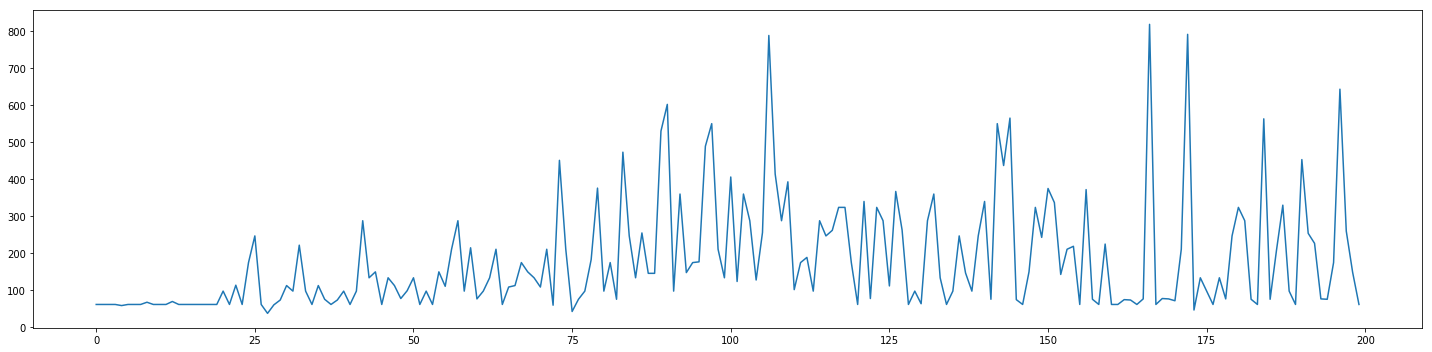

In [6]:


# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()



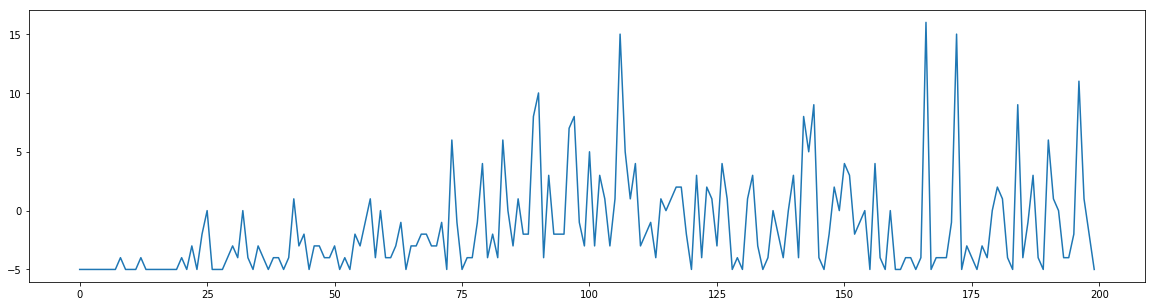

In [7]:
# plot reward against training episodes
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()